**Описание проекта**

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В распоряжении набор данных с разметкой о токсичности правок. Получить метрики качества F1 не меньше 0.75. 

**Алгоритм решения** 

- Загрузить и подготовить данные.
- Обучить разные модели.
- Сделайть выводы.


**Описание данных**

Данные находятся в файле /datasets/toxic_comments.csv.
Столбец text в нём содержит текст комментария, а toxic — целевой признак.

In [1]:
!pip install matplotlib==3.7.1 -q
!pip install wordcloud==1.8.2.2 -q
!pip install --upgrade Pillow==9.5.0 -q
!pip install spacy -q
!python -m spacy download en_core_web_sm -q
!pip install tqdm -q
!pip install --upgrade pandas~=1.4.3 -q

import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from scipy.stats import loguniform
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from nltk.sentiment import SentimentIntensityAnalyzer


from sklearn.linear_model import PassiveAggressiveClassifier
from tqdm.notebook import tqdm
tqdm.pandas() 
import spacy
from wordcloud import WordCloud
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")

  error: subprocess-exited-with-error
  
  exit code: 1
  
  [32 lines of output]
  BLIS_COMPILER? None
  C:\Users\mrbus\AppData\Local\Temp\pip-build-env-y7n0r67a\overlay\Lib\site-packages\setuptools\dist.py:759: SetuptoolsDeprecationWarning: License classifiers are deprecated.
  !!
  
          ********************************************************************************
          Please consider removing the following classifiers in favor of a SPDX license expression:
  
          License :: OSI Approved :: BSD License
  
          See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
          ********************************************************************************
  
  !!
    self._finalize_license_expression()
  running bdist_wheel
  running build
  running build_py
  creating build\lib.win-amd64-cpython-39\blis
  copying blis\about.py -> build\lib.win-amd64-cpython-39\blis
  copying blis\benchmark.py -> build\lib.win-amd64-cpyth

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


  You can safely remove it manually.
  You can safely remove it manually.
C:\Users\mrbus\anaconda3\envs\Practicum\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Подготовка

### Считаем CSV-файл с данными с помощью библиотеки pandas и сохраним его в датафрейм

In [3]:
data = pd.read_csv(r'C:\Users\mrbus\Downloads\toxic_comments.csv', index_col=0)

In [4]:
data.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [6]:
data.isna().sum()

text     0
toxic    0
dtype: int64

In [7]:
data.duplicated().sum()

0

In [8]:
data['toxic'].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

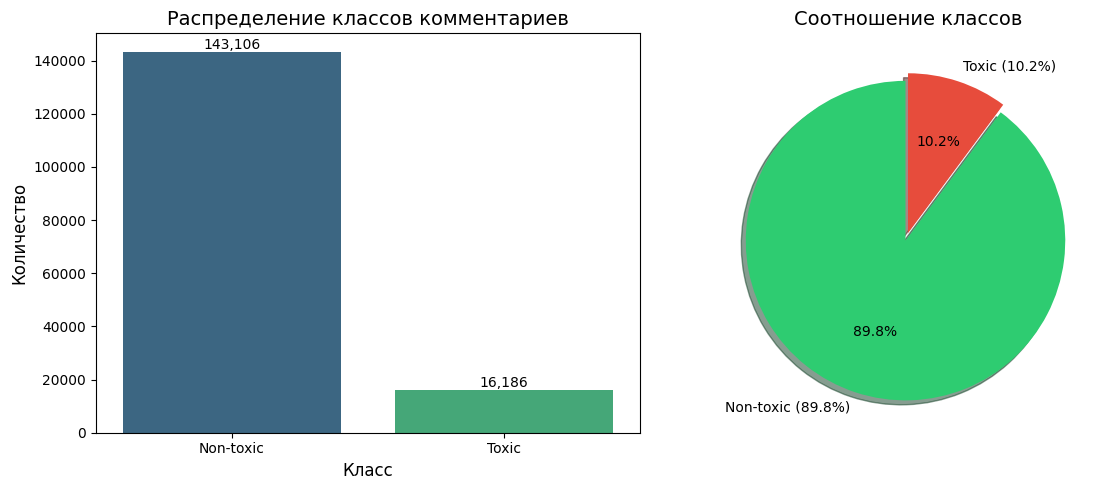

In [9]:
class_dist = data['toxic'].value_counts(normalize=True) * 100
labels = [f'Non-toxic ({class_dist[0]:.1f}%)', 
          f'Toxic ({class_dist[1]:.1f}%)']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
ax = sns.countplot(x='toxic', data=data, palette='viridis')
plt.title('Распределение классов комментариев', fontsize=14)
plt.xlabel('Класс', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks([0,1], ['Non-toxic', 'Toxic'])

for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.subplot(1, 2, 2)
plt.pie(class_dist, 
        labels=labels, 
        colors=['#2ecc71', '#e74c3c'], 
        autopct='%1.1f%%',
        startangle=90,
        explode=(0.05, 0),
        shadow=True)
plt.title('Соотношение классов', fontsize=14)

plt.tight_layout()
plt.show()

In [10]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mrbus\AppData\Roaming\nltk_data...


In [11]:
def text_features(df):
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
    df['char_per_word'] = df['text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]) 
                                       if len(str(x).split()) > 0 else 0)
    df['sentiment'] = df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])
    return df

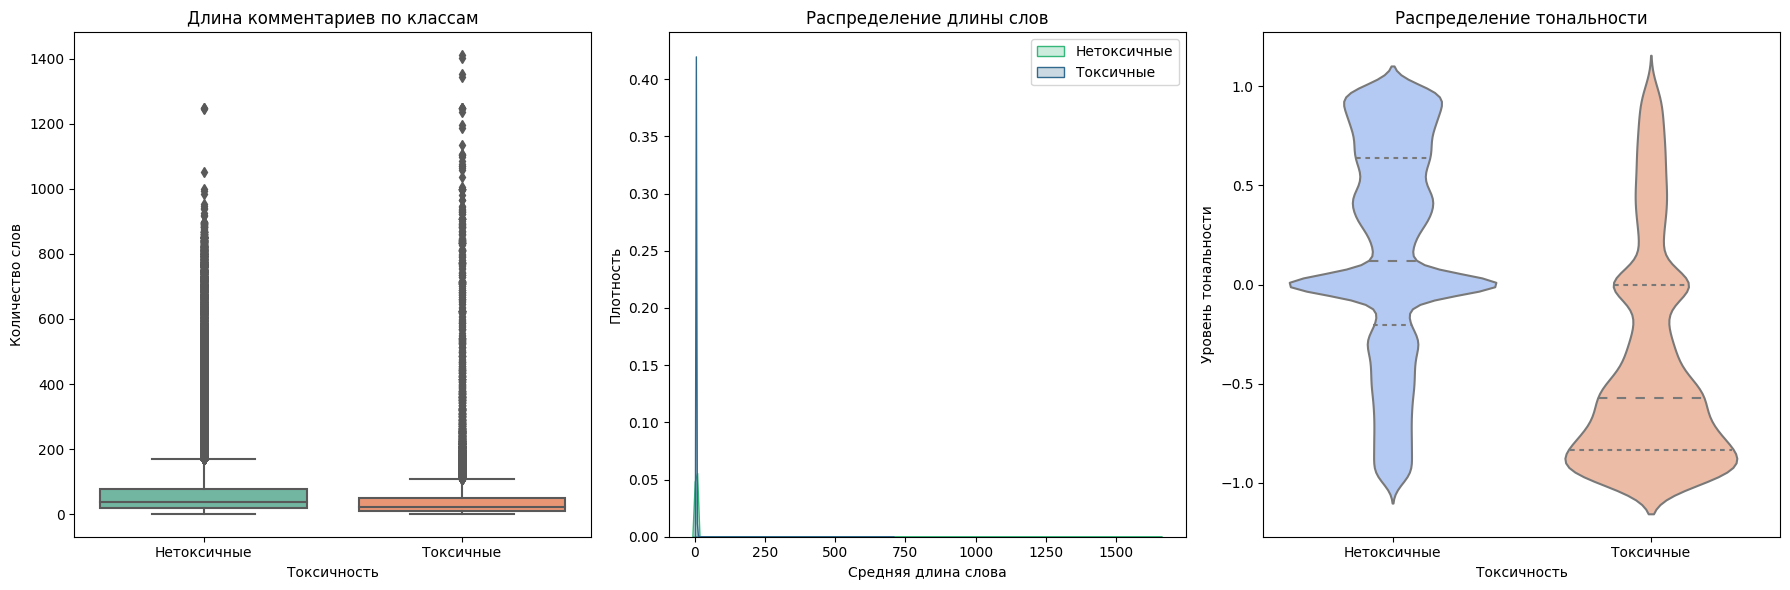

In [12]:
data = text_features(data)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.boxplot(x='toxic', y='word_count', data=data, palette='Set2')
plt.title('Длина комментариев по классам', fontsize=12)
plt.xlabel('Токсичность', fontsize=10)
plt.ylabel('Количество слов', fontsize=10)
plt.xticks([0, 1], ['Нетоксичные', 'Токсичные'])

plt.subplot(1, 3, 2)
sns.kdeplot(data=data, x='char_per_word', hue='toxic', 
          palette='viridis', fill=True, common_norm=False)
plt.title('Распределение длины слов', fontsize=12)
plt.xlabel('Средняя длина слова', fontsize=10)
plt.ylabel('Плотность', fontsize=10)
plt.legend(['Нетоксичные', 'Токсичные'])

plt.subplot(1, 3, 3)
sns.violinplot(x='toxic', y='sentiment', data=data, 
             palette='coolwarm', inner='quartile')
plt.title('Распределение тональности', fontsize=12)
plt.xlabel('Токсичность', fontsize=10)
plt.ylabel('Уровень тональности', fontsize=10)
plt.xticks([0, 1], ['Нетоксичные', 'Токсичные'])

plt.tight_layout()
plt.show()

In [13]:
plt.style.use('ggplot')
stop_words = set(stopwords.words('english'))

In [14]:
def generate_text(df, target):
    text = ' '.join(df[df['toxic'] == target]['text'])
    text = re.sub(r'[^a-zA-Z]', ' ', text.lower())
    words = [word for word in text.split() if word not in stop_words]
    return ' '.join(words)

In [15]:
toxic_text = generate_text(data, 1)
nontoxic_text = generate_text(data, 0)

In [16]:
def plot_cloud(text, title, color):
    plt.figure(figsize=(10, 6))
    cloud = WordCloud(width=800, 
                     height=400, 
                     background_color='white',
                     colormap=color,
                     max_words=100,
                     stopwords=stop_words).generate(text)
    
    plt.imshow(cloud, interpolation='bilinear')
    plt.title(title, fontsize=16, pad=20)
    plt.axis('off')
    plt.show()

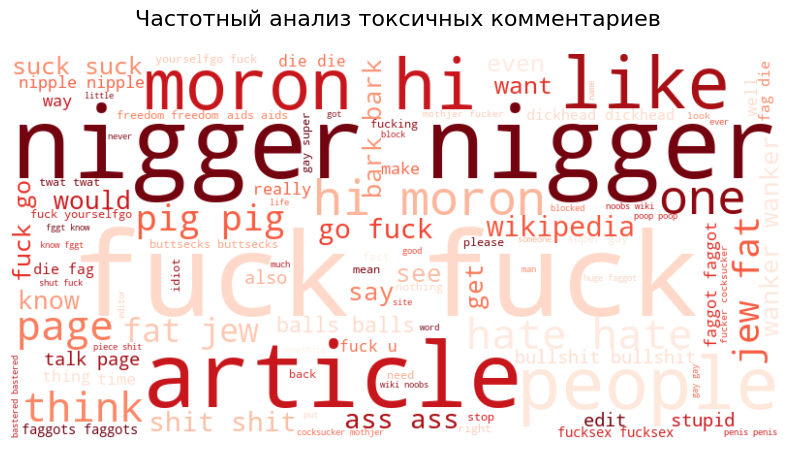

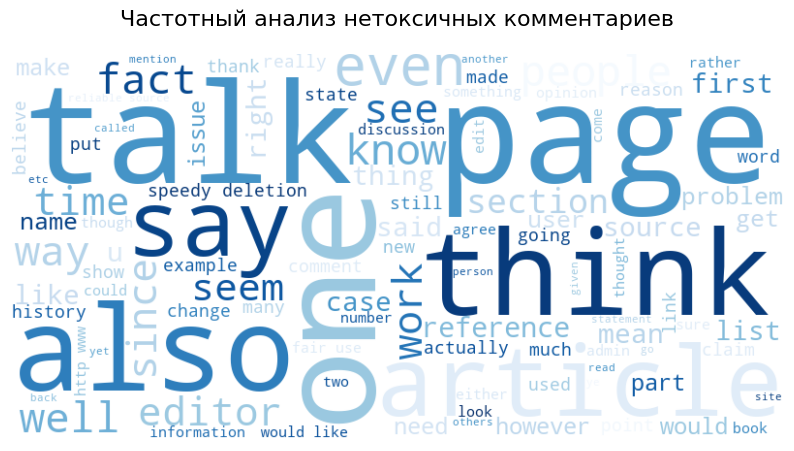

In [17]:
plot_cloud(toxic_text, 
          'Частотный анализ токсичных комментариев', 
          'Reds')


plot_cloud(nontoxic_text, 
          'Частотный анализ нетоксичных комментариев', 
          'Blues')

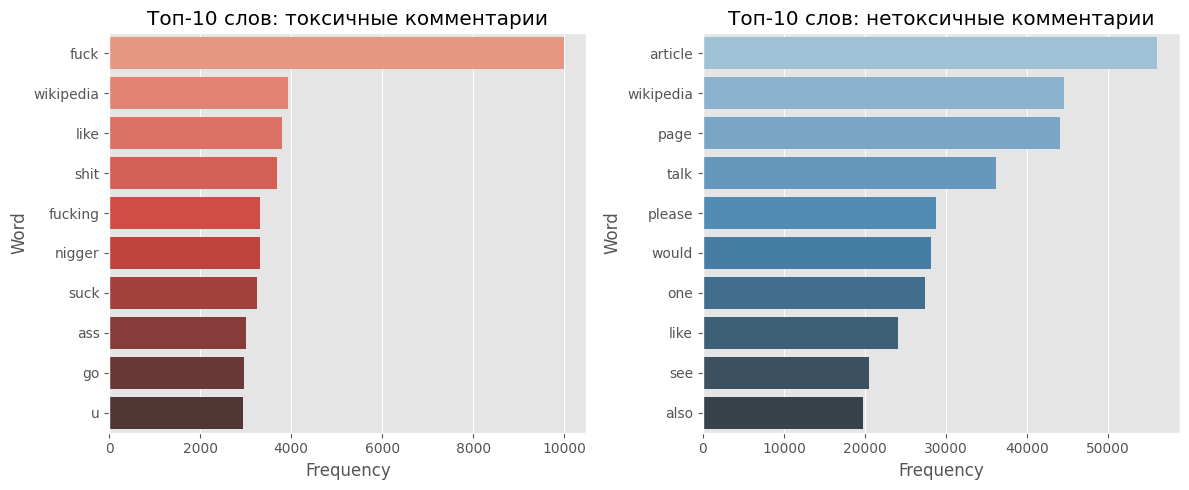

In [18]:
def top_words(text, n=10):
    words = text.split()
    freq_dist = nltk.FreqDist(words)
    return pd.DataFrame(freq_dist.most_common(n),
                       columns=['Word', 'Frequency'])

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
top_toxic = top_words(toxic_text)
sns.barplot(x='Frequency', y='Word', data=top_toxic, palette='Reds_d')
plt.title('Топ-10 слов: токсичные комментарии')

plt.subplot(1, 2, 2)
top_nontoxic = top_words(nontoxic_text)
sns.barplot(x='Frequency', y='Word', data=top_nontoxic, palette='Blues_d')
plt.title('Топ-10 слов: нетоксичные комментарии')

plt.tight_layout()
plt.show()

Пропусков и явных дубликатов в данных нет, наблюдается дисбаланс классов.

### Предобработка текста

In [19]:
#def preprocess(text):
#    text = re.sub(r'http\S+|www\S+|@\w+|#\w+|[^a-zA-Z ]', ' ', str(text))
#    text = text.lower().strip()
#    tokens = nltk.word_tokenize(text)
#    tokens = [lemmatizer.lemmatize(word) for word in tokens 
#              if word not in stop_words and len(word) > 2]
#    return ' '.join(tokens)

In [20]:
#nltk.download(['stopwords', 'punkt', 'wordnet'])
#stop_words = set(stopwords.words('english'))
#lemmatizer = WordNetLemmatizer()

In [21]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def preprocess_spacy(text):
    text = re.sub(r'http\S+|www\S+|@\w+|#\w+|[^a-zA-Z]', ' ', str(text))
    text = text.lower().strip()
    
    doc = nlp(text)
    tokens = [
        token.lemma_ 
        for token in doc 
        if not token.is_stop 
           and len(token.text) > 2 
           and token.is_alpha
    ]
    
    return ' '.join(tokens)

In [22]:
data['processed'] = data['text'].progress_apply(preprocess_spacy)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    data['processed'],
    data['toxic'],
    test_size=0.2,
    stratify=data['toxic'],
    random_state=42
)

## Обучение

In [24]:
def train_model(model, params, n_iter=15):
    pipeline = ImbPipeline([
        ('tfidf', TfidfVectorizer(
            min_df=5,
            max_features=15000,
            ngram_range=(1,3),
            sublinear_tf=True
        )),
        ('smote', SMOTE(
            random_state=42,
            sampling_strategy=0.3,
            k_neighbors=5
        )),
        ('model', model)
    ])
    
    search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=params,
        n_iter=n_iter,
        scoring='f1',
        cv=3,
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    search.fit(X_train, y_train)
    
    print(f"\n{model.__class__.__name__}:")
    print(f"Лучший F1 (CV): {search.best_score_:.4f}")
    print(f"Лучшие параметры: {search.best_params_}")
    
    return search

In [25]:
lr_params = {
    'model__C': loguniform(1e-3, 10),
    'model__penalty': ['l2', 'elasticnet'],
    'model__solver': ['saga'],
    'model__l1_ratio': [0.4, 0.5, 0.6],
    'tfidf__max_features': [12000, 15000],
    'tfidf__ngram_range': [(1,2), (1,3)],
    'smote__k_neighbors': [3, 5]
}

rf_params = {
    'model__n_estimators': [200, 300],
    'model__max_depth': [30, 50, None],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__class_weight': ['balanced_subsample'],
    'tfidf__max_features': [10000, 12000],
    'tfidf__ngram_range': [(1,3)],
    'smote__k_neighbors': [3, 5]
}

pa_params = {
    'model__C': loguniform(1e-4, 10),
    'model__max_iter': [1000],
    'tfidf__max_features': [15000, 20000],
    'tfidf__ngram_range': [(1, 2), (1, 3)],
    'smote__k_neighbors': [3, 5]
}

In [26]:
best_models = {}

In [27]:
lr_search = train_model(
    LogisticRegression(
        max_iter=2000,
        random_state=42,
        warm_start=True
    ),
    lr_params,
    n_iter=20
)
best_models['LogisticRegression'] = lr_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits

LogisticRegression:
Лучший F1 (CV): 0.7707
Лучшие параметры: {'model__C': 0.44677528179739034, 'model__l1_ratio': 0.5, 'model__penalty': 'elasticnet', 'model__solver': 'saga', 'smote__k_neighbors': 5, 'tfidf__max_features': 15000, 'tfidf__ngram_range': (1, 3)}


In [28]:
rf_search = train_model(
    RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        verbose=0
    ),
    rf_params,
    n_iter=15
)
best_models['RandomForest'] = rf_search.best_estimator_

Fitting 3 folds for each of 15 candidates, totalling 45 fits

RandomForestClassifier:
Лучший F1 (CV): 0.7225
Лучшие параметры: {'tfidf__ngram_range': (1, 3), 'tfidf__max_features': 10000, 'smote__k_neighbors': 5, 'model__n_estimators': 300, 'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_depth': None, 'model__class_weight': 'balanced_subsample'}


In [29]:
pa_search = train_model(
    PassiveAggressiveClassifier(
        random_state=42,
        class_weight='balanced'
    ),
    pa_params
)

best_models['PassiveAggressive'] = pa_search.best_estimator_

Fitting 3 folds for each of 15 candidates, totalling 45 fits

PassiveAggressiveClassifier:
Лучший F1 (CV): 0.6566
Лучшие параметры: {'model__C': 0.007459343285726546, 'model__max_iter': 1000, 'smote__k_neighbors': 3, 'tfidf__max_features': 15000, 'tfidf__ngram_range': (1, 2)}


In [30]:
searches = {
    'LogisticRegression': lr_search,
    'RandomForest': rf_search,
    'PassiveAggressive': pa_search
}

best_models = {name: search.best_estimator_ for name, search in searches.items()}

best_model_name = max(searches, key=lambda x: searches[x].best_score_)
best_model = best_models[best_model_name]

In [31]:
y_pred = best_model.predict(X_test)
test_f1 = f1_score(y_test, y_pred)

In [32]:
print("\n" + "="*50)
print(f"Лучшая модель: {best_model_name}")
print(f"F1 на тестовых данных: {test_f1:.4f}")
print("Использованные параметры:")
print(best_model.named_steps['model'])
print("="*50)


Лучшая модель: LogisticRegression
F1 на тестовых данных: 0.7799
Использованные параметры:
LogisticRegression(C=0.44677528179739034, l1_ratio=0.5, max_iter=2000,
                   penalty='elasticnet', random_state=42, solver='saga',
                   warm_start=True)


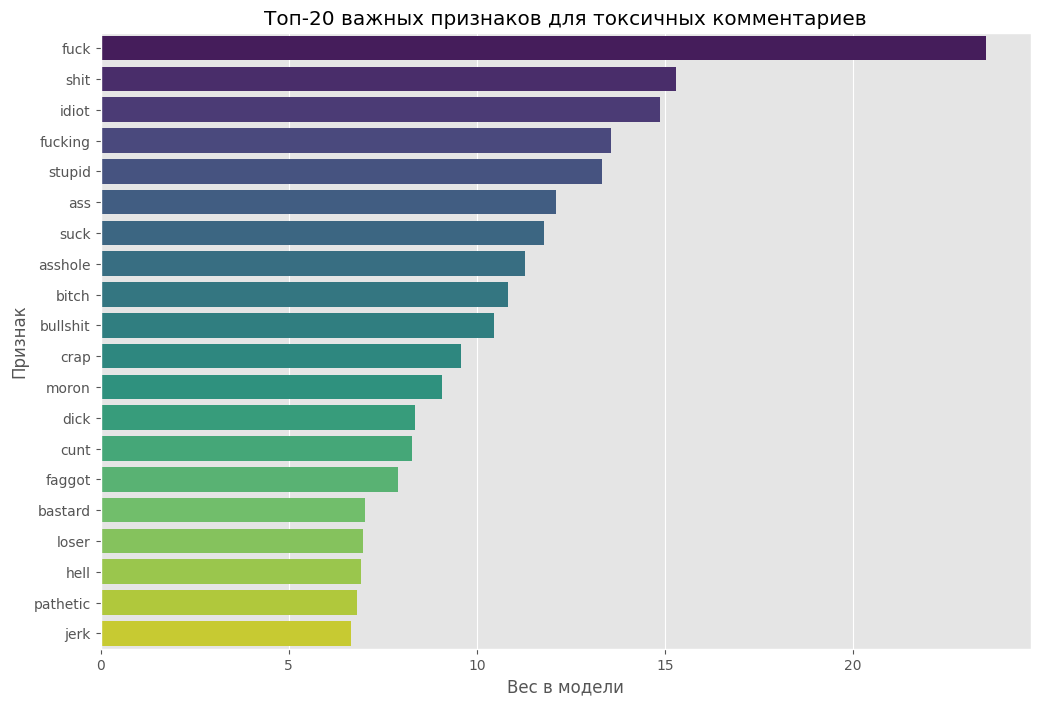

In [33]:
feature_names = best_model.named_steps['tfidf'].get_feature_names_out()
coefs = best_model.named_steps['model'].coef_[0]

top_features = pd.DataFrame({
    'feature': feature_names,
    'weight': coefs
}).sort_values('weight', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x='weight', y='feature', data=top_features, palette='viridis')
plt.title('Топ-20 важных признаков для токсичных комментариев')
plt.xlabel('Вес в модели')
plt.ylabel('Признак')
plt.show()

Только LogisticRegression удовлетворяет условию, что f1 не меньше 0.75

## Выводы

В ходе выпонения работы требовалось выполнить следующую задачу: создать нструмент, который будет искать токсичные комментарии и отправлять их на модерацию.


Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В распоряжении набор данных с разметкой о токсичности правок. Получить метрики качества F1 не меньше 0.75.


Данные были загружен и изучены: пропусков и дубликатов обнаружено не было, но наблюдался сильный дисбаланс классов.


После этого текст был предобработан: удалены специфические паттерны и символы, произведена токенизация и лемматизация.

Далее, были обучны модели LogisticRegression и RandomForest. Лучшей моделью оказалась LogisticRegression с гиперпараметрами: LogisticRegression(C=0.44677528179739034, l1_ratio=0.5, max_iter=2000,
                   penalty='elasticnet', random_state=42, solver='saga',
                   warm_start=True)

Удалось достичь метрики 0.7729 на тестовой выборке.